# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

In [88]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.head(20)

,TM_A,TM_B,target
0,Simoniz,Permanize,1
1,Magnavoc,Multivox,1
2,Zirco,Cozirc,1
3,Platinum Puff,Platinum Plus,1
4,Maternity Yours,Your Maternity Shop,1
5,Flossies,Flossbone,1
6,Hypnotiq,Hopnotic,1
7,Woody Stout,Woody Brown Ale,1
8,Frickin’ Chicken,Flip’n Chicken,1
9,Alair,Holaira,1


In [94]:
foo = featurize(cases)


foo.head(20)

,a,b,target,TM_A,TM_B,partial,tkn_sort,tkn_set,levenshtein,metaphone,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
0,Simoniz,Permanize,1,simoniz,permanize,57,50,50,0.161290,0,...,0.666667,0.555556,0.137931,0.566667,0.671958,0.430556,0.444444,0.654902,0.602128,0.727599
1,Magnavoc,Multivox,1,magnavoc,multivox,38,38,38,0.161290,0,...,0.500000,0.500000,0.304348,0.400000,0.583333,0.375000,0.375000,0.916667,0.545455,0.897177
2,Zirco,Cozirc,1,zirco,cozirc,89,73,73,0.096774,0,...,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
3,Platinum Puff,Platinum Plus,1,platinumpuff,platinumplus,83,83,83,0.096774,0,...,0.500000,0.833333,0.666667,0.833333,0.888889,0.769231,0.833333,1.000000,0.873529,0.913978
4,Maternity Yours,Your Maternity Shop,1,maternityyours,yourmaternityshop,74,65,65,0.290323,0,...,0.000000,0.588235,0.319149,0.538235,0.687675,0.490372,0.588235,0.463725,0.589655,0.646110
5,Flossies,Flossbone,1,flossies,flossbone,62,71,71,0.129032,0,...,0.666667,0.611111,0.382353,0.700000,0.805556,0.588889,0.666667,0.890196,0.617647,0.822581
6,Hypnotiq,Hopnotic,1,hypnotiq,hopnotic,75,75,75,0.064516,1,...,0.666667,0.875000,0.826087,0.875000,0.777778,0.750000,0.750000,0.967157,0.784091,0.979839
7,Woody Stout,Woody Brown Ale,1,woodystout,woodybrownale,60,52,52,0.225806,0,...,0.500000,0.538462,0.105263,0.550000,0.687179,0.441142,0.461538,0.835294,0.485714,0.727047
8,Frickin’ Chicken,Flip’n Chicken,1,frickinchicken,flipnchicken,75,77,77,0.129032,0,...,0.666667,0.785714,0.500000,0.757143,0.782540,0.708791,0.642857,0.919118,0.758537,0.835253
9,Alair,Holaira,1,alair,holaira,80,67,67,0.096774,0,...,0.833333,0.642857,0.045455,0.671429,0.790476,0.547619,0.571429,0.795588,0.636364,0.686636


In [43]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [44]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [45]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [46]:
from abydos.phones import *

In [47]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [48]:
import re

In [49]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    

    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
#     df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [ ]:


# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

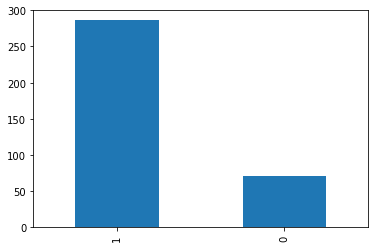

In [87]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [10]:
from itertools import combinations
import random
random.seed(42)


In [37]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=200), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

,TM_A,TM_B
0,Platinum Plus,Jaked
1,ROOM SEVEN,Willow Tree Gin
2,DWELL STUDENT,Tatadoo
3,Miltron,Flossbone
4,PERCIPIO BY SKILLSOFT,Britsa
...,...,...
195,Rad,WHEALTH HEALTH IS THE REAL WEALTH
196,Candey Parker,MILAN
197,GURU,UBS SMARTWEALTH
198,Nivalin,PAPA


In [38]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:0


In [39]:
nonmatch_cases.sample(20)

,TM_A,TM_B
180,Luted,Zero
136,Cresco,Sabis.
22,GREY FAMOUSLY EFFECTIVE,Curve
191,GORILLA,ELEGANT RESORTS
143,Lutetxal,Nature Research Society
77,ENVY,NERO EXPRESS
49,HORIZON,GARDEN PARTY HIRE
192,Nature Research Society,Snow Globe
61,DENIM,Gaziantep Pastanesi
53,Groundtruth,BLUE.COM


In [40]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

class_balanced

# class_balanced[class_balanced['TM_B'].str.len()!=0]


,TM_A,TM_B,target
0,Simoniz,Permanize,1
1,Magnavoc,Multivox,1
2,Zirco,Cozirc,1
3,Platinum Puff,Platinum Plus,1
4,Maternity Yours,Your Maternity Shop,1
...,...,...,...
352,Lilton,Wilton,0
353,Nutricia,Nutritea,0
354,Glenreidh,An Reidhe,0
355,No Gunk No Junk,No Gunk Just Funk,0


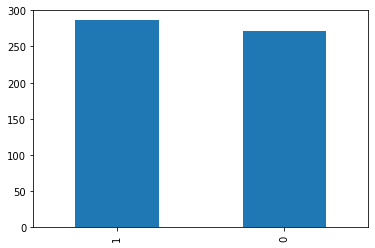

In [86]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [50]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

/Users/seannguyen/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,a,b,target,TM_A,TM_B,partial,tkn_sort,tkn_set,levenshtein,metaphone,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
88,RedInside,Inside,1,redinside,inside,100,80,80,0.088235,0,...,0.666667,0.666667,0.275862,0.794444,0.777778,0.621032,0.666667,0.676471,0.638298,0.666667
145,WINSTON,DUNSTON,1,winston,dunston,71,71,71,0.058824,0,...,0.833333,0.785714,0.545455,0.742857,0.809524,0.714286,0.714286,0.858824,0.853659,0.928571
37,INVESTED. TOGETHER.,GREYBOX,0,investedtogether,greybox,29,17,17,0.411765,0,...,0.000000,0.218750,0.000000,0.381250,0.470238,0.000000,0.125000,0.472549,0.182955,0.391129
170,Horse of London,WHEALTH HEALTH IS THE REAL WEALTH,0,horseoflondon,whealthhealthistherealwealth,31,20,20,0.705882,0,...,0.000000,0.339286,0.000000,0.419643,0.400183,0.000000,0.107143,0.806863,0.179054,0.421659
253,DIXIE UNION,DIXY CHICKEN,1,dixieunion,dixychicken,50,57,57,0.205882,0,...,0.000000,0.545455,0.161290,0.618182,0.651515,0.409091,0.454545,0.878431,0.442623,0.781525
275,MILAN,MILAN SWEETS,1,milan,milansweets,100,62,62,0.176471,0,...,0.000000,0.590909,0.083333,0.645455,0.818182,0.263456,0.454545,0.904902,0.473684,0.454545
168,Panadol,Fizz Fitness,0,panadol,fizzfitness,14,11,11,0.323529,0,...,0.000000,0.409091,0.000000,0.359091,0.000000,0.000000,0.000000,0.691176,0.243077,0.568915
198,Nivalin,PAPA,0,nivalin,papa,25,18,18,0.176471,0,...,0.000000,0.285714,0.000000,0.171429,0.464286,0.061905,0.142857,0.765686,0.186486,0.502304
164,Amberstone,Fizz Fitness,0,amberstone,fizzfitness,30,29,29,0.264706,0,...,0.000000,0.272727,0.000000,0.318182,0.421212,0.242424,0.272727,0.576471,0.398462,0.687683
64,Hypnotiq,FWDVIEW,0,hypnotiq,fwdview,14,13,13,0.235294,0,...,0.000000,0.187500,0.000000,0.212500,0.422619,0.097222,0.125000,0.835294,0.263636,0.721774


#### Export clean data to csv

In [ ]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [51]:
y = df.target
X = df.drop(columns = 'target')

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## TPOT AutoML pipeline

In [ ]:
from tpot import TPOTClassifier

In [ ]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [ ]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [ ]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [54]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

,target,partial,tkn_sort,tkn_set,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
0,1,57,50,50,0.147059,0,0,0,0,0.485480,...,0.666667,0.555556,0.137931,0.566667,0.671958,0.430556,0.444444,0.654902,0.602128,0.727599
1,1,38,38,38,0.147059,0,0,0,0,0.050000,...,0.500000,0.500000,0.304348,0.400000,0.583333,0.375000,0.375000,0.916667,0.545455,0.897177
2,1,89,73,73,0.088235,0,0,0,0,0.821263,...,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
3,1,83,83,83,0.088235,0,0,0,1,0.884677,...,0.500000,0.833333,0.666667,0.833333,0.888889,0.769231,0.833333,1.000000,0.873529,0.913978
4,1,74,65,65,0.264706,0,0,0,0,0.951613,...,0.000000,0.588235,0.319149,0.538235,0.687675,0.490372,0.588235,0.463725,0.589655,0.646110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0,83,83,83,0.029412,0,0,0,0,0.897436,...,0.833333,0.833333,0.500000,0.833333,0.822222,0.833333,0.833333,0.866667,0.823529,0.943548
353,0,75,75,75,0.058824,0,0,0,1,0.804167,...,0.833333,0.812500,0.565217,0.787500,0.833333,0.750000,0.750000,0.997549,0.937500,0.973790
354,0,80,71,71,0.117647,0,0,0,0,0.800858,...,0.666667,0.666667,0.310345,0.666667,0.741402,0.588889,0.666667,0.784804,0.705882,0.655914
355,0,67,77,77,0.147059,0,0,0,1,0.852383,...,0.833333,0.678571,0.469388,0.700000,0.815873,0.637363,0.714286,0.995588,0.713415,0.808756


In [55]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

In [56]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5, min_samples_leaf=10,
                               min_samples_split=3, n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)
results = exported_pipeline.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print(results)

[1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0
 0]


In [57]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

In [58]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [59]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

[0.7069017697558038,
 0.1893016682775248,
 0.6899157015859401,
 0.657969928782682,
 0.7276388834438425,
 0.18721021632905702,
 0.22790955120512332,
 0.7409692654604867,
 0.7403735492636494,
 0.6664559609158602,
 0.7582887349118884,
 0.7127580369607229,
 0.1865387736673108,
 0.7203506857966585,
 0.6501550746656481,
 0.714133130229465,
 0.6336771474178828,
 0.6551698387063519,
 0.666998413476144,
 0.1865387736673108,
 0.7078174614599473,
 0.6944310883618859,
 0.6902173627868277,
 0.7022752288648767,
 0.6962117627676679,
 0.6201078848252889,
 0.1865387736673108,
 0.23946521129402148,
 0.6639297129614886,
 0.2757878180437188,
 0.7010621683533614,
 0.18721021632905702,
 0.4177546807685363,
 0.6732056908585328,
 0.6994374000784123,
 0.5035306524428051,
 0.7405049406733901,
 0.6829060163115299,
 0.6740126259180926,
 0.7717472979892662,
 0.7344594955207592,
 0.6866400193960941,
 0.6649298778075543,
 0.7398309088886101,
 0.6797832934186846,
 0.6772148494250324,
 0.7387250745541272,
 0.687810042

## K-fold cross validation

In [60]:
from sklearn.model_selection import StratifiedKFold

In [61]:
# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

#     oof_pred['siamese_sim'] = base_model_2(X_train[['name_a', 'name_b']],
#                                       y_train,
#                                       X_test[['name_a', 'name_b']])
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-61-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

completed fold 1 of 10
completed fold 2 of 10


<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-61-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

completed fold 3 of 10
completed fold 4 of 10


<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-61-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

completed fold 5 of 10
completed fold 6 of 10


<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-61-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-61-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-61-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [92]:
meta_training.sample(20)


,TM_A,TM_B,predict_proba,target
319,giftobay,ebay,0.705537,0
133,dermaveel,dermawell,0.727301,1
327,ooohfudge,oohchocolata,0.491571,0
328,mobe,mobicard,0.673090,0
71,vype,mideltone,0.194714,0
81,woodybrownale,fab,0.244852,0
42,londonresi,biobooster,0.211906,0
19,groundtruth,imperialreserva,0.200449,0
346,go,shellgo,0.626098,0
113,elysium,gorilla,0.195731,0


### Meta-Model: Logistic Regression

In [63]:
df=featurize(meta_training)

In [85]:
df.sample(20)

,a,b,predict_proba,target,TM_A,TM_B,partial,tkn_sort,tkn_set,levenshtein,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
292,eezeevet,easipetcarelowcostvetswhocare,0.381372,0,eezeevet,easipetcarelowcostvetswhocare,38,32,32,0.676471,...,0.000000,0.293103,0.000000,0.408621,0.541188,0.000000,0.172414,0.914706,0.167347,0.271413
118,greybox,grey,0.756781,1,greybox,grey,100,73,73,0.088235,...,0.666667,0.571429,0.409091,0.571429,0.857143,0.490476,0.571429,0.968627,0.540541,0.571429
102,shortlyster,shortlister,0.728391,1,shortlyster,shortlister,91,91,91,0.029412,...,1.000000,0.954545,0.944444,0.990909,0.939394,0.909091,0.909091,1.000000,0.984615,0.997067
152,nextdealshop,seven,0.199776,0,nextdealshop,seven,20,24,24,0.294118,...,0.000000,0.291667,0.000000,0.345833,0.505556,0.000000,0.166667,0.795098,0.150000,0.376344
122,tata,camcap,0.334406,0,tata,camcap,50,40,40,0.117647,...,0.000000,0.333333,0.000000,0.475000,0.611111,0.300000,0.333333,0.924020,0.470588,0.607527
176,classview,seven,0.243328,0,classview,seven,60,43,43,0.176471,...,0.500000,0.388889,0.068966,0.455556,0.540741,0.232143,0.333333,0.848529,0.372340,0.482079
67,gideonsuk,gideon,0.717324,1,gideonsuk,gideon,100,80,80,0.088235,...,0.666667,0.666667,0.458333,0.677778,0.888889,0.621032,0.666667,0.918627,0.638298,0.666667
309,mcq,ukmq,0.425037,0,mcq,ukmq,67,57,57,0.088235,...,0.000000,0.375000,0.263158,0.475000,0.527778,0.350000,0.500000,0.742157,0.500000,0.649194
232,urbaneat,urbanstreet,0.713551,1,urbaneat,urbanstreet,75,74,74,0.117647,...,0.666667,0.681818,0.166667,0.736364,0.789502,0.607071,0.545455,0.793627,0.540984,0.718475
142,greyfamouslyeffective,beautifuleffective,0.685398,1,greyfamouslyeffective,beautifuleffective,67,67,67,0.264706,...,0.500000,0.595238,0.344262,0.578571,0.791005,0.564035,0.619048,0.742157,0.661682,0.794163


### Evaluate Gradient Boosting Classifier

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[22  5]
 [ 3 25]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           1       0.83      0.89      0.86        28

    accuracy                           0.85        55
   macro avg       0.86      0.85      0.85        55
weighted avg       0.86      0.85      0.85        55



In [ ]:
# df_confusion.to_csv('TM_GBC_Confusion_matris.csv')

In [74]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

NameError: name 'grid_clf2' is not defined

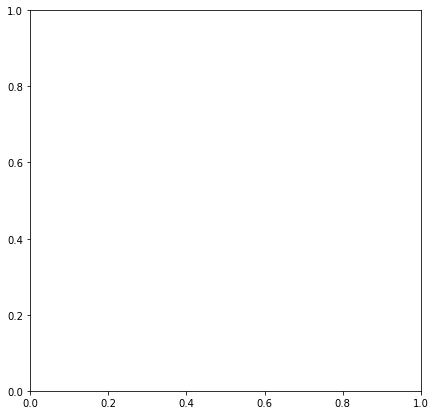

In [75]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf2.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('TM_GBC_ROC.png', dpi = 300)

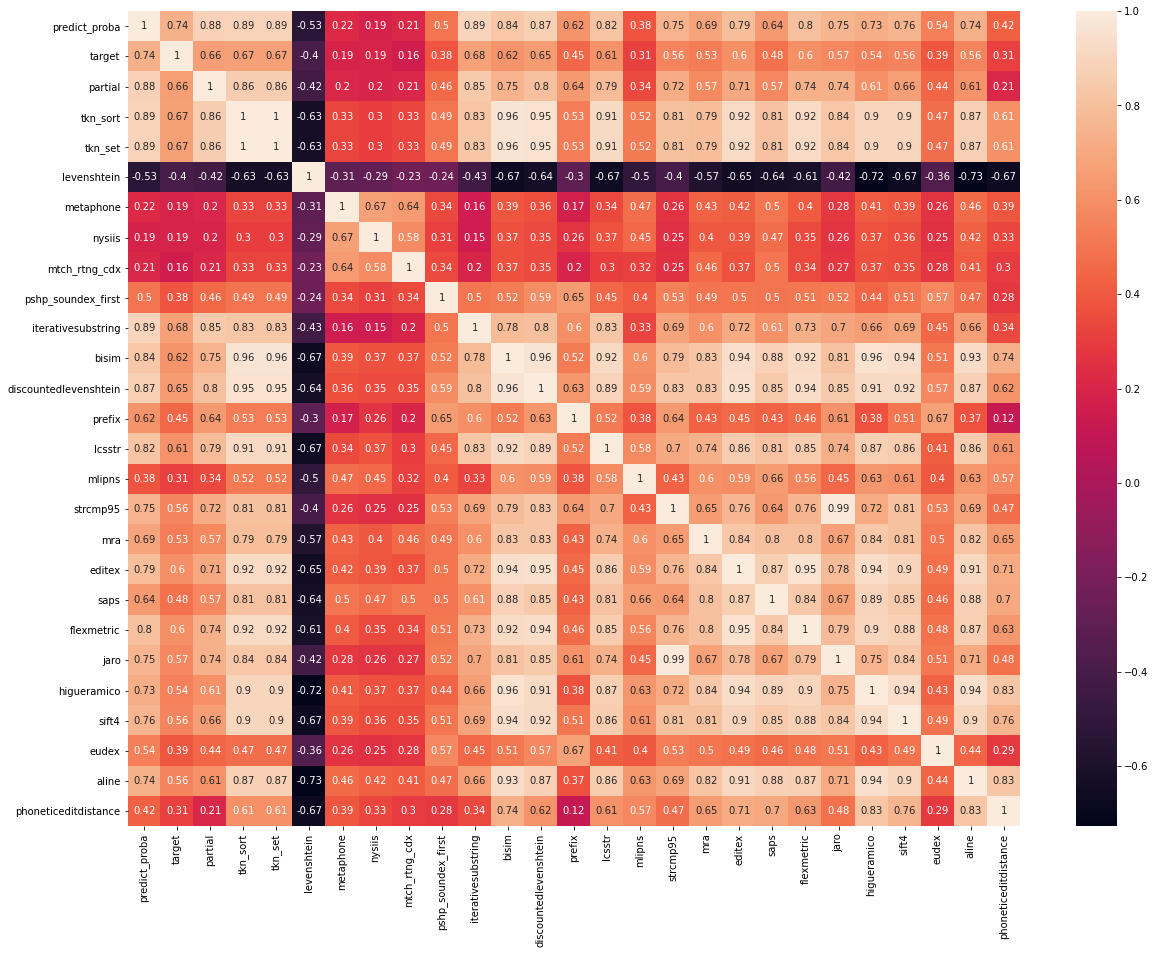

In [76]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True)
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Grid Search   

Hyperparameter tuning?

In [80]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [83]:
scores_df = pd.DataFrame(scores)

NameError: name 'scores' is not defined

In [84]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

NameError: name 'scores_df' is not defined

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['predict_proba', 'tkn_set', 'iterativesubstring', 'strcmp95']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [77]:
from sklearn.metrics import classification_report

In [78]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [79]:
evaluate(y_test, y_pred)

NameError: name 'y_pred' is not defined

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')

### TPOT AutoML Regression

In [ ]:
from tpot import TPOTRegressor

pipeline_optimizer = TPOTRegressor(
        scoring = 'f1', 
        generations=100,
        verbosity=2,
        n_jobs=-1   # Utilizes all available CPU cores
        ) 
pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

exported_pipeline = make_pipeline(